# **imports**

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report


**Dataset loading**

In [ ]:
import kagglehub, os

dataset_path = kagglehub.dataset_download("ealaxi/paysim1")
csv_path = os.path.join(dataset_path, "PS_20174392719_1491204439457_log.csv")

df = pd.read_csv(csv_path, low_memory=False)

df = df[[
    "step", "type", "amount",
    "oldbalanceOrg", "newbalanceOrig",
    "oldbalanceDest", "newbalanceDest",
    "isFraud"
]]

df["type"] = df["type"].map({
    "CASH_IN": 0,
    "CASH_OUT": 1,
    "DEBIT": 2,
    "PAYMENT": 3,
    "TRANSFER": 4
})


Using Colab cache for faster access to the 'paysim1' dataset.


**Proper unsupervised split**

In [ ]:
X = df.drop("isFraud", axis=1)
y = df["isFraud"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Keep ONLY normal for training
X_train = X_train[y_train == 0]

# Validation set (normal only)
X_train, X_val = train_test_split(X_train, test_size=0.1, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

input_dim = X_train.shape[1]


**AUTOENCODER (AE)**

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))


**AE Training (correct early stopping)**

In [ ]:
ae = Autoencoder(input_dim)
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)

train_loader = DataLoader(TensorDataset(X_train), batch_size=512, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val), batch_size=512)

best_loss = np.inf
patience = 7
counter = 0

for epoch in range(50):
    ae.train()
    for (x,) in train_loader:
        optimizer.zero_grad()
        loss = criterion(ae(x), x)
        loss.backward()
        optimizer.step()

    ae.eval()
    val_loss = 0
    with torch.no_grad():
        for (x,) in val_loader:
            val_loss += criterion(ae(x), x).item()

    print(f"AE Epoch {epoch+1} | Val loss: {val_loss:.6f}")

    if val_loss < best_loss:
        best_loss = val_loss
        best_state = ae.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping AE")
            break

ae.load_state_dict(best_state)


AE Epoch 1 | Val loss: 0.893411
AE Epoch 2 | Val loss: 0.680534
AE Epoch 3 | Val loss: 0.931349
AE Epoch 4 | Val loss: 0.491308
AE Epoch 5 | Val loss: 0.598321
AE Epoch 6 | Val loss: 0.811031
AE Epoch 7 | Val loss: 0.439410
AE Epoch 8 | Val loss: 0.218217
AE Epoch 9 | Val loss: 0.259609
AE Epoch 10 | Val loss: 0.308128
AE Epoch 11 | Val loss: 0.175610
AE Epoch 12 | Val loss: 0.179523
AE Epoch 13 | Val loss: 0.470702
AE Epoch 14 | Val loss: 0.465756
AE Epoch 15 | Val loss: 0.171156
AE Epoch 16 | Val loss: 0.689136
AE Epoch 17 | Val loss: 0.206305
AE Epoch 18 | Val loss: 0.133276
AE Epoch 19 | Val loss: 0.352886
AE Epoch 20 | Val loss: 0.150124
AE Epoch 21 | Val loss: 0.085805
AE Epoch 22 | Val loss: 0.217837
AE Epoch 23 | Val loss: 0.403080
AE Epoch 24 | Val loss: 0.145065
AE Epoch 25 | Val loss: 0.229478
AE Epoch 26 | Val loss: 0.200693
AE Epoch 27 | Val loss: 0.086877
AE Epoch 28 | Val loss: 0.183386
Early stopping AE


<All keys matched successfully>

**AE Evaluation (TRUE unsupervised threshold)**

In [ ]:
ae.eval()
with torch.no_grad():
    recon = ae(X_test).numpy()

recon_error = np.mean((X_test.numpy() - recon) ** 2, axis=1)

# Percentile threshold (industry standard)
threshold = np.percentile(recon_error, 99.5)

y_pred_ae = (recon_error > threshold).astype(int)

print("\n=== Autoencoder (Unsupervised) ===")
print("Threshold:", threshold)
print(classification_report(y_test, y_pred_ae, digits=4))



=== Autoencoder (Unsupervised) ===
Threshold: 0.003958569
              precision    recall  f1-score   support

           0     0.9992    0.9955    0.9973   1270881
           1     0.0938    0.3634    0.1491      1643

    accuracy                         0.9946   1272524
   macro avg     0.5465    0.6794    0.5732   1272524
weighted avg     0.9980    0.9946    0.9962   1272524



**PROFESSIONAL β-VAE**

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=8):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        self.mu = nn.Linear(32, latent_dim)
        self.logvar = nn.Linear(32, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = self.mu(h), self.logvar(h)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


**β-VAE Loss (KEY FIX)**

In [ ]:
def vae_loss(recon_x, x, mu, logvar, beta=0.001):
    recon = nn.MSELoss(reduction='mean')(recon_x, x)
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + beta * kl


**VAE Training**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vae = VAE(input_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

patience = 5
best_loss = np.inf
counter = 0

for epoch in range(50):
    vae.train()
    total_loss = 0

    for x in train_loader:
        if isinstance(x, (list, tuple)):
            x = x[0]
        x = x.to(device)

        optimizer.zero_grad()
        x_hat, mu, logvar = vae(x)
        loss = vae_loss(x_hat, x, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)

    epoch_loss = total_loss / len(train_loader.dataset)
    print(f"VAE Epoch {epoch+1} | Loss: {epoch_loss:.6f}")

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_state = vae.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping VAE")
            break

vae.load_state_dict(best_state)


VAE Epoch 1 | Loss: 0.015000
VAE Epoch 2 | Loss: 0.003925
VAE Epoch 3 | Loss: 0.002988
VAE Epoch 4 | Loss: 0.002751
VAE Epoch 5 | Loss: 0.002555
VAE Epoch 6 | Loss: 0.002334
VAE Epoch 7 | Loss: 0.008590
VAE Epoch 8 | Loss: 0.002171
VAE Epoch 9 | Loss: 0.002779
VAE Epoch 10 | Loss: 0.002770
VAE Epoch 11 | Loss: 0.002234
VAE Epoch 12 | Loss: 0.008555
VAE Epoch 13 | Loss: 0.002984
Early stopping VAE


<All keys matched successfully>

**VAE Evaluation**

In [ ]:
# ----------------------------
# VAE Evaluation (CORRECT)
# ----------------------------
vae.eval()
with torch.no_grad():
    recon_vae, _, _ = vae(X_test.to(device))
    recon_error_vae = torch.mean(
        (X_test.to(device) - recon_vae) ** 2,
        dim=1
    ).cpu().numpy()

# Threshold from NORMAL validation data
with torch.no_grad():
    recon_val_vae, _, _ = vae(X_val.to(device))
    recon_error_val_vae = torch.mean(
        (X_val.to(device) - recon_val_vae) ** 2,
        dim=1
    ).cpu().numpy()

threshold_vae = np.percentile(recon_error_val_vae, 99.5)
y_pred_vae = (recon_error_vae > threshold_vae).astype(int)

print("\n=== Variational Autoencoder (VAE) ===")
print("Threshold:", threshold_vae)
print(classification_report(y_test, y_pred_vae, digits=4))



=== Variational Autoencoder (VAE) ===
Threshold: 0.0058107376
              precision    recall  f1-score   support

           0     0.9992    0.9953    0.9973   1270881
           1     0.1033    0.4218    0.1659      1643

    accuracy                         0.9945   1272524
   macro avg     0.5513    0.7085    0.5816   1272524
weighted avg     0.9981    0.9945    0.9962   1272524



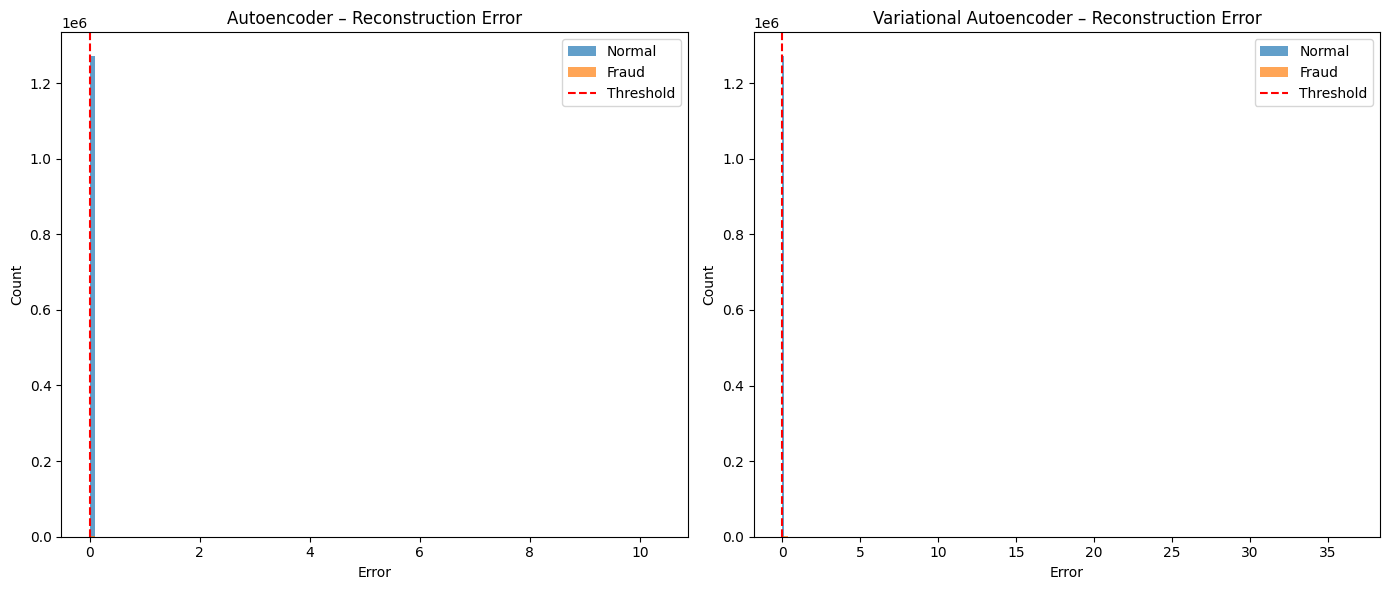

In [ ]:
y_np = y_test.values if hasattr(y_test, "values") else np.array(y_test)

# VAE
vae_normal = recon_error_vae[y_np == 0]
vae_fraud  = recon_error_vae[y_np == 1]

# AE
ae_normal = recon_error_ae[y_np == 0]
ae_fraud  = recon_error_ae[y_np == 1]

plt.figure(figsize=(14,6))

# VAE
plt.subplot(1,2,2)
plt.hist(vae_normal, bins=100, alpha=0.7, label="Normal")
plt.hist(vae_fraud, bins=100, alpha=0.7, label="Fraud")
plt.axvline(threshold_vae, color="red", linestyle="--", label="Threshold")
plt.title("Variational Autoencoder – Reconstruction Error")
plt.xlabel("Error")
plt.ylabel("Count")
plt.legend()

# AE
plt.subplot(1,2,1)
plt.hist(ae_normal, bins=100, alpha=0.7, label="Normal")
plt.hist(ae_fraud, bins=100, alpha=0.7, label="Fraud")
plt.axvline(threshold_ae, color="red", linestyle="--", label="Threshold")
plt.title("Autoencoder – Reconstruction Error")
plt.xlabel("Error")
plt.ylabel("Count")
plt.legend()

plt.tight_layout()
plt.show()
